# Deep Learning: common issues and solutions

This notebook presenting various techniques must be handed in. It will be marked.
You must add your own comments and tests. It is the comments and your own tests that will be assessed.
* Commentary when comparing different approaches
* Own test, when testing different parameters

**Aglind Reka**

In [114]:
import pandas as pd
import numpy as np

In [115]:
import matplotlib.pyplot as plt

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [117]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

In [118]:
### Some global constant
epochs=100
batch_size=256
patience=10
hidden_dim=256

In [120]:
### Usual function for babysit the network

# It is important to systematically observe the learning curves
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+ key], label="val_" + key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

In [121]:
### Usual callback for training deep learning model

# It is important to use early stopping systematically
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]

## 1. Today lab

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

As you did in the previous lab, the goal is to try to predict the 'Rating' after reading the 'Reviews'.
We will mostly use this dataset as a case study to illustrate issues that you can have using Multilayer Perceptron or other Deep Learning architectures, namely:

1) **Text preprocessing with Tensorflow API**

2) **The vanishing gradient problem**:

Problem: Your model does not learn at all !
    
3) **Underfitting and Overfitting problems**
Problems:

    - Underfitting relates to the fact that your model does not learn enough on the train dataset to hope for good generalization abilities (good label prediction on new samples with unknown labels).
    - Overfitting means that your model fits too much to the train dataset, which can also prevents it from generalizing well to new samples with unknown labels.
    
4) **Starting, stopping, and resuming training**

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! 

5) Find best hyper-parameters with keras-tuner

## 2. Dataset pre-processing

In this lab, we will just re-use the dataset of previous lab providing Sentiment Analysis tasks. 
And we will stick to the tf-idf approach for word embeddings. 

### a) Essential reminder [About Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

**If you use cross validation, concatenate Train and Validation set.**

In [122]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### b) Build X (features vectors) and y (labels)

In [123]:
# Construct X_train and y_train
X_train = np.array(TRAIN['Reviews'].fillna("")).reshape((-1,1))
y_train = np.array(TRAIN['Rating']).reshape((-1,1))
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [124]:
# Construct X_test and y_test
X_test = np.array(TEST['Reviews'].fillna("")).reshape((-1,1))
y_test = np.array(TEST['Rating']).reshape((-1,1))
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

In [125]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.transform(y_test)

In [126]:
y_test_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [127]:
# Define constant
n_classes = len(np.unique(y_train))
feature_vector_length = X_train.shape[1]

feature_vector_length, n_classes

(1, 5)

## 3. Text preprocessing with tensorflow

So far we have used `sklearn.feature_extraction.text.CountVectorize` or `sklearn.feature_extraction.text.TfidfVectorize` preceded by our own preprocessing to transform a text sequence into a vector. Unfortunately it is not possible to integrate this into a 'tensorflow' pipeline or vice versa, integrating a Tensorflow network into a sklearn pipeline is not easy. 

Fortunately, Tensorflow has a similar function: [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

Look at the Tensorflow documentation to understand how it works.

The main parameter is output_mode:
* "int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
    * give an ID for each token
    
Below is a small example of use

In [128]:
corpus = ["I love chocolate and I hate beer",
          "I love beer and I hate chocolate",
          "I love beer and I love chocolate"]
corpus = tf.convert_to_tensor(corpus)

for output_mode in ['multi_hot', 'count', 'tf_idf', 'int']:
    print("-"*50)
    print("output_mode:", output_mode)
    vectorize_layer = layers.TextVectorization(output_mode=output_mode)
    vectorize_layer.adapt(corpus) # Do the same thinks as fit in sklearn library
    print(vectorize_layer.get_vocabulary())
    print(vectorize_layer(corpus))


--------------------------------------------------
output_mode: multi_hot
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: count
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 2. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: tf_idf
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 1.1192316 0.5596158 0.5596158 0.5596158 0.       ]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: int
['', '[UNK]', 'i', 'love', 'chocolate', 'beer', 'an

<font color="red">[TO DO STUDENTS]</font>

It is up to you to build examples with the other parameters of the TextVectorization function

In [129]:
#Example
for max_len in [4,8,12]:
    vectorize_layer = layers.TextVectorization(output_mode="int",output_sequence_length=max_len)
    vectorize_layer.adapt(corpus) # Do the same thinks as fit in sklearn library
    print(vectorize_layer.get_vocabulary())
    print(vectorize_layer(corpus))

['', '[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[2 3 4 6]
 [2 3 5 6]
 [2 3 5 6]], shape=(3, 4), dtype=int64)
['', '[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[2 3 4 6 2 7 5 0]
 [2 3 5 6 2 7 4 0]
 [2 3 5 6 2 3 4 0]], shape=(3, 8), dtype=int64)
['', '[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[2 3 4 6 2 7 5 0 0 0 0 0]
 [2 3 5 6 2 7 4 0 0 0 0 0]
 [2 3 5 6 2 3 4 0 0 0 0 0]], shape=(3, 12), dtype=int64)


<font color="red">[ TO DO STUDENTS]</font>

Initialize your vectorizer layer according to the training data

In [130]:
""" Your code here """
vectorize_layer = layers.TextVectorization(output_mode="multi_hot",split="whitespace") ##I'm using multi_hot
vectorize_layer.adapt(X_train)

In [131]:
vectorize_layer(X_train)

<tf.Tensor: shape=(5000, 11001), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

## 3. Vanishing gradient problem

This problem can be encountered when training NN with gradient-based learning methods and backpropagation. In such methods, during each iteration of training each of the neural network's weights receives an update proportional to the partial derivative of the loss function with respect to the current weight. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. This mostly occurs when your architecture counts too many parameters to learn.

Possible solutions, obviously with their pros and cons: 

* Reduce the depth of your network.
* Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
* Use residual connections, i.e output at each layer: layer(input) + input
* Use normalization techniques, e.g Batch Normalization and so on.

### a) Observe the vanishing gradient problem

<font color="red">[ TO DO STUDENTS]</font>

Design a function to simply build MLP with the following inputs, which return the model ready to compile:

* vectorizer: the vectorizer layer used to transform a sentence in a vector</font>
* activation: activation used at each hidden layer
* n_hiddenlayers: number of hidden layers in the network
* hidden_dim: shared number of neurons within each hidden layer

In [132]:
#this is the model

def build_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    """ Your code here """
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    #x = Dense(units=hidden_dim, activation=activation)(inputs)
    for i in range(n_hiddenlayers-1):
        x = Dense(units=hidden_dim, activation=activation)(x)
    outputs = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

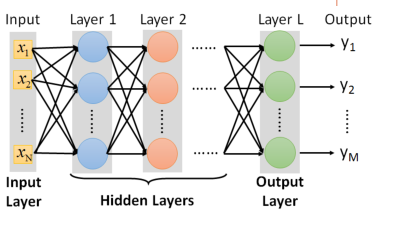

In the code below I'm creating the model with 30 hidden layers, like is showed in the picture above (example taken from the slides) 

In [133]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorize_layer, 'tanh', 30, hidden_dim)

In [134]:
#I'm going to print the summary
# Print the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_11 (Text  (None, 11001)            0         
 Vectorization)                                                  
                                                                 
 dense_33 (Dense)            (None, 256)               2816512   
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 256)               65792     
                                                           

In [135]:
#pip install pydot
from tensorflow.keras.utils import plot_model

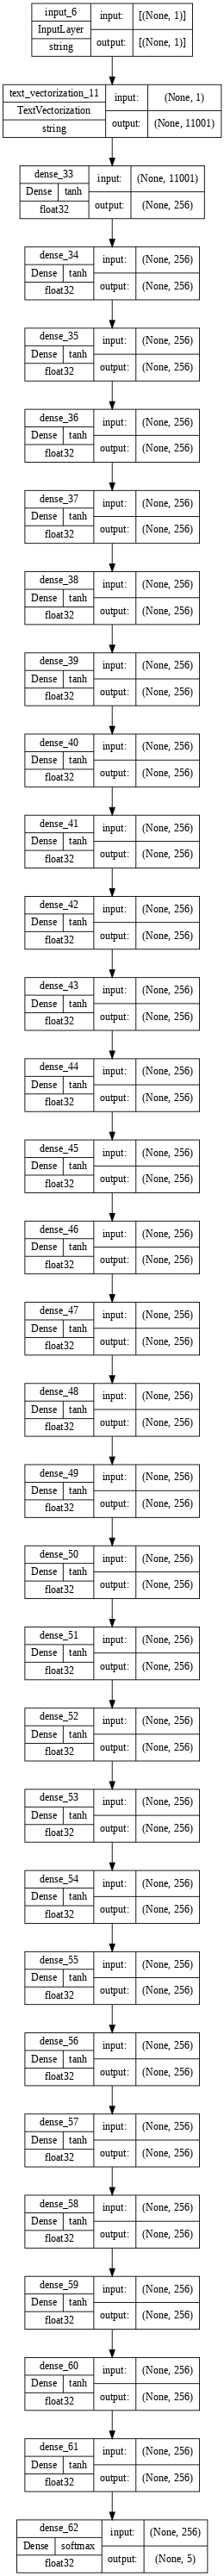

In [136]:
# Plot the model
#pip install pydot

plot_model(model, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

<font color="red">You now know 2 ways to view your network. You can choose the one you prefer.</font>

In [137]:
# Configure the model and start training, use the defined early stopping
""" your code here """
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

#In this point I'm fitting/training the model

Epoch 1/100
125/125 [==============================] - 7s 45ms/step - loss: 1.1611 - accuracy: 0.5817 - val_loss: 1.0954 - val_accuracy: 0.6040
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 0.9597 - accuracy: 0.6520 - val_loss: 0.9551 - val_accuracy: 0.6480
Epoch 3/100
125/125 [==============================] - 5s 38ms/step - loss: 0.8649 - accuracy: 0.6862 - val_loss: 0.9408 - val_accuracy: 0.6570
Epoch 4/100
125/125 [==============================] - 5s 38ms/step - loss: 0.7888 - accuracy: 0.7113 - val_loss: 0.9425 - val_accuracy: 0.6670
Epoch 5/100
125/125 [==============================] - 5s 38ms/step - loss: 0.7418 - accuracy: 0.7222 - val_loss: 0.9667 - val_accuracy: 0.6500
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 0.6837 - accuracy: 0.7477 - val_loss: 1.0502 - val_accuracy: 0.6580
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 0.6332 - accuracy: 0.7655 - val_loss: 0.9934 - val_accuracy:

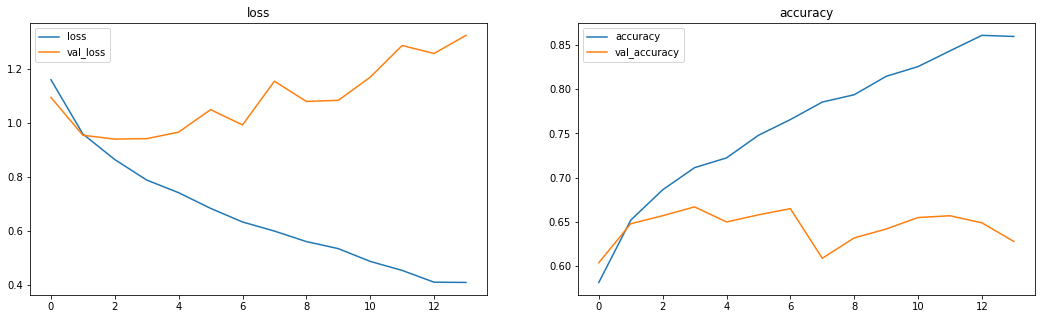

In [138]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history.history)

Like I see in the two plots, I've a overfitting  -> means that my model fits too much to the train dataset.The model fits very well with the training data but it performs porly with the validation data. So I can say that my model is learning only with the training data and not generalazing well.

<font color="red">[ TO DO STUDENTS]</font>

Is your network learning? Check your intuition by evaluating your model and looking at the confusion matrix.

In [139]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test_encoded, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 0s 57ms/step - loss: 0.9558 - accuracy: 0.6770
test loss, test acc: [0.9557695388793945, 0.6769999861717224]


In [140]:
y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test_encoded.argmax(axis=1), y_pred.argmax(axis=1))

32/32 [==============================] - 1s 14ms/step


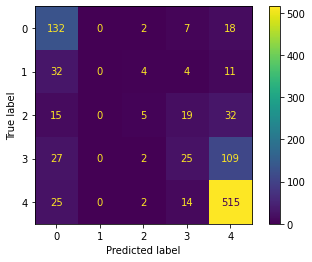

In [141]:
# Print/plot the confusion matrix
""" your code here """
ConfusionMatrixDisplay(matrix).plot()

Like I see from the confusion matrix, a loot of data are incorect classified, so I can conferm that the performance of my model are bad.

### b) Experiment on ReLU activation

<font color="red">[ TO DO STUDENTS]</font>

Change activation from 'tanh' to 'relu', still with a deep network.

In [142]:
# Build a network with 30 hidden layers with 'relu' activations this time
model_second = build_model(vectorize_layer, 'relu', 30, hidden_dim)

In [143]:
# Configure the model and start training
""" your code here """
model_second.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 5s 39ms/step - loss: 0.7303 - accuracy: 0.7320 - val_loss: 0.9909 - val_accuracy: 0.6640
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 0.6803 - accuracy: 0.7527 - val_loss: 1.0690 - val_accuracy: 0.6620
Epoch 3/100
125/125 [==============================] - 5s 37ms/step - loss: 0.6483 - accuracy: 0.7645 - val_loss: 0.9938 - val_accuracy: 0.6390
Epoch 4/100
125/125 [==============================] - 5s 37ms/step - loss: 0.5994 - accuracy: 0.7835 - val_loss: 1.0353 - val_accuracy: 0.6460
Epoch 5/100
125/125 [==============================] - 5s 37ms/step - loss: 0.5518 - accuracy: 0.8012 - val_loss: 1.1546 - val_accuracy: 0.6000
Epoch 6/100
125/125 [==============================] - 5s 37ms/step - loss: 0.5261 - accuracy: 0.8185 - val_loss: 1.1151 - val_accuracy: 0.6460
Epoch 7/100
125/125 [==============================] - 5s 37ms/step - loss: 0.5138 - accuracy: 0.8167 - val_loss: 1.1801 - val_accuracy:

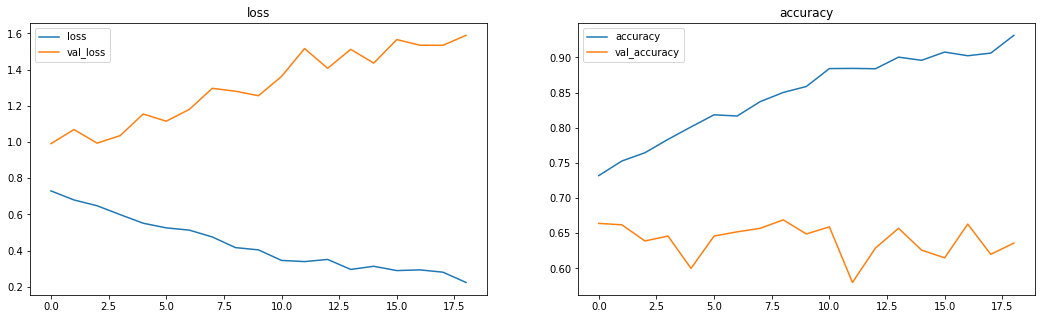

In [144]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history.history)

Even in this example I see the same problem of overfittin, like I see in the two plots. The accoracy on training data keep increasing, and the occuracy on validation it's low, so even in this case dosen't generalize well the data.

<font color="red">[ TO DO STUDENTS]</font>

Does the network learn better? Does the network perform well? Study the learning curves and justify your statements with the study of its performance (classification report and confusion matrix)

In [145]:

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_second = model_second.evaluate(X_test, y_test_encoded, batch_size=batch_size)
print("test loss, test acc:", results_second)

Evaluate on test data
4/4 [==============================] - 1s 53ms/step - loss: 1.6094 - accuracy: 0.1590
test loss, test acc: [1.6094375848770142, 0.1589999943971634]


32/32 [==============================] - 0s 13ms/step


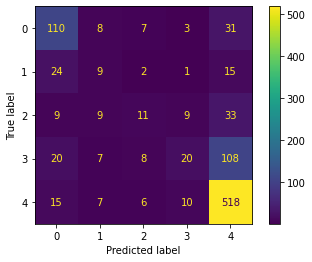

In [146]:
y_pred_second = model.predict(X_test)

matrixsecond = confusion_matrix(y_test_encoded.argmax(axis=1), y_pred_second.argmax(axis=1))

ConfusionMatrixDisplay(matrixsecond).plot()

I can confirm what I said before seeing even the confusion matrix, the data are incorrect classified. In my case I don't see a big difference because the model in the train set performs well but not well in the validation.

On my code, it seems that the ReLU activation for sparsity has helped to solve the problem, but the model still struggles to learn and to get good performance on the validation set.

### c) Experiment on residual connections

<font color="red">[ TO DO STUDENTS ]<color>
* Create a function to generate models with residual connections.
* Using ReLU activation + residual connections, are you able to get better results ?
* Provide here a description of the learning and performances of your network
* Compare it to previous models. What are your conclusions ?

In [149]:
def build_residual_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    """ Your code here """
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string) #N_features should be shape of X_train
    x = vectorize_layer(inputs)

   
    x = Dense(units=hidden_dim, activation=activation)(x)
    y = Dense(units=hidden_dim, activation=activation)(x)
    for i in range(n_hiddenlayers-1):    
        y = Dense(units=hidden_dim, activation=activation)(y)

    #y = x+y    
    y = layers.Add()([x,y])

    outputs = Dense(n_classes,activation='softmax')(y)           #output regression, for example: regression it be 1
    model = Model(inputs, outputs)
    return model

Now I'm going to build the model with residuals connections and I'll see if the model performs better then the previus one.

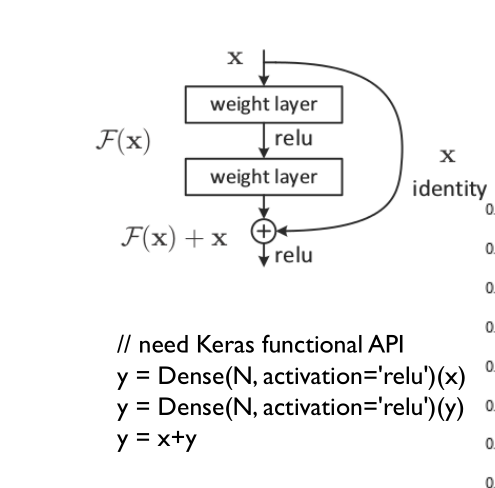

In [150]:
# Build a network with 30 hidden layers with 'relu' activations
model_res = build_residual_model(vectorize_layer, 'relu', 30, hidden_dim)

In [151]:
# Print and plot the model --> What is the best solution ?
model_res.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_res = model_res.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 6s 41ms/step - loss: 1.4013 - accuracy: 0.5332 - val_loss: 1.2928 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 1.2632 - accuracy: 0.5357 - val_loss: 1.2266 - val_accuracy: 0.5550
Epoch 3/100
125/125 [==============================] - 5s 38ms/step - loss: 1.2053 - accuracy: 0.5443 - val_loss: 1.1907 - val_accuracy: 0.5730
Epoch 4/100
125/125 [==============================] - 5s 38ms/step - loss: 1.1635 - accuracy: 0.5595 - val_loss: 1.1606 - val_accuracy: 0.5840
Epoch 5/100
125/125 [==============================] - 5s 37ms/step - loss: 1.1265 - accuracy: 0.5775 - val_loss: 1.1331 - val_accuracy: 0.5900
Epoch 6/100
125/125 [==============================] - 5s 38ms/step - loss: 1.0923 - accuracy: 0.5943 - val_loss: 1.1091 - val_accuracy: 0.6040
Epoch 7/100
125/125 [==============================] - 5s 37ms/step - loss: 1.0606 - accuracy: 0.6087 - val_loss: 1.0861 - val_accuracy:

In [152]:
#the summary of the model
model_res.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_11 (TextVec  (None, 11001)       0           ['input_8[0][0]']                
 torization)                                                                                      
                                                                                                  
 dense_93 (Dense)               (None, 256)          2816512     ['text_vectorization_11[2][0]']  
                                                                                                  
 dense_94 (Dense)               (None, 256)          65792       ['dense_93[0][0]']         

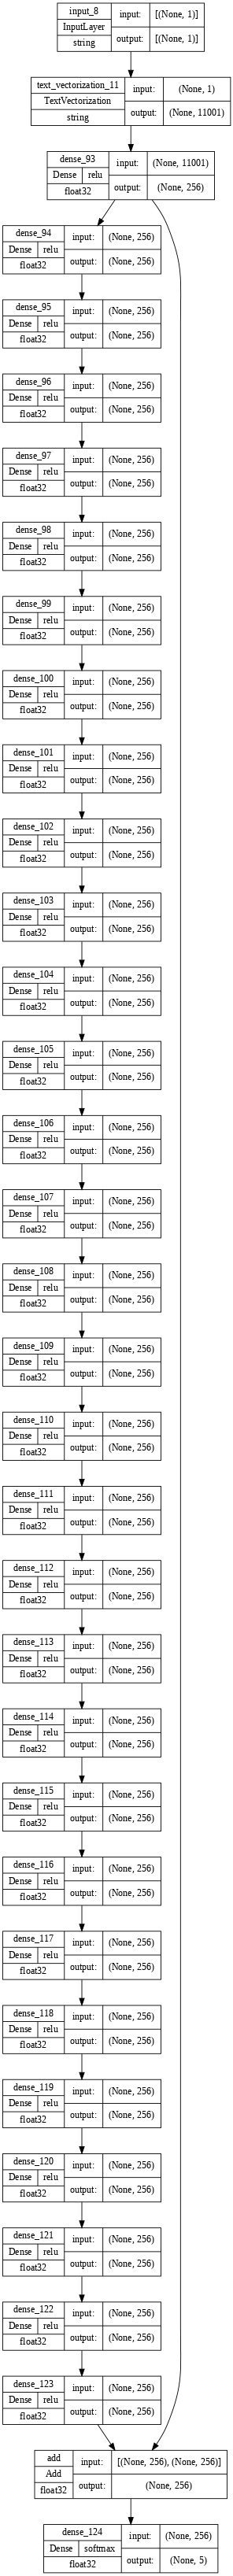

In [153]:

plot_model(model_res, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

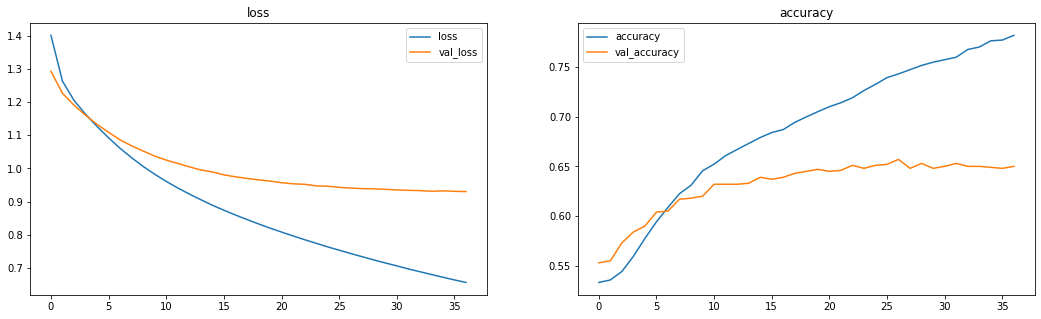

In [154]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_res.history)

Right now I can see better performance of the model, like I see on the plot, the model is learning not only in the train set but even in validation, less but better than in the previus models.

### d) Experiment on Batch Normalization

<font color="red">[ TO DO STUDENTS ]</font>
* step1: adapt build_model function to add batch normalization layers after the output of the hidden dense layers. 
* step2: adapt build_model function to use batch normalization layers and residuals
             
* In both case use ReLU activation and 30 hidden layers as previouly
* Compare your results

In [173]:
from keras.layers import BatchNormalization
def build_model_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    """ Your code here """
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    
    
    for i in range(n_hiddenlayers-1):
      x = BatchNormalization()(x)
      x = Dense(units=hidden_dim, activation=activation)(x)
      
      

    outputs = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

In [181]:
def build_residual_model_residual_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    """ your code here """

    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    
   


      
    
    for i in range(n_hiddenlayers-1): 
      x = BatchNormalization()(x)
      x = Dense(units=hidden_dim, activation=activation)(x) 
      y = Dense(units=hidden_dim, activation=activation)(x)  
      y = Dense(units=hidden_dim, activation=activation)(y)

    #y = x+y    
    y = layers.Add()([x,y])


    outputs = Dense(n_classes,activation='softmax')(y)
    model = Model(inputs, outputs)

    return model

In [174]:
#Build and train the network with BatchNormalization layer
model_bn = build_model_batch_normalization(vectorize_layer, 'relu', 30, hidden_dim)

# Configure the model and start training
""" your code here """
model_bn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_bn = model_bn.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 17s 67ms/step - loss: 1.4293 - accuracy: 0.4692 - val_loss: 1.4024 - val_accuracy: 0.5520
Epoch 2/100
125/125 [==============================] - 7s 59ms/step - loss: 1.3557 - accuracy: 0.5005 - val_loss: 1.3424 - val_accuracy: 0.5120
Epoch 3/100
125/125 [==============================] - 7s 58ms/step - loss: 1.3371 - accuracy: 0.5070 - val_loss: 1.3752 - val_accuracy: 0.5100
Epoch 4/100
125/125 [==============================] - 7s 60ms/step - loss: 1.3181 - accuracy: 0.5128 - val_loss: 1.3672 - val_accuracy: 0.5360
Epoch 5/100
125/125 [==============================] - 9s 69ms/step - loss: 1.3083 - accuracy: 0.5140 - val_loss: 1.4302 - val_accuracy: 0.5000
Epoch 6/100
125/125 [==============================] - 7s 58ms/step - loss: 1.2949 - accuracy: 0.5170 - val_loss: 1.3835 - val_accuracy: 0.5390
Epoch 7/100
125/125 [==============================] - 8s 60ms/step - loss: 1.2923 - accuracy: 0.5200 - val_loss: 1.4185 - val_accuracy

In [175]:
model_bn.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_11 (Text  (None, 11001)            0         
 Vectorization)                                                  
                                                                 
 batch_normalization_61 (Bat  (None, 11001)            44004     
 chNormalization)                                                
                                                                 
 dense_278 (Dense)           (None, 256)               2816512   
                                                                 
 batch_normalization_62 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                           

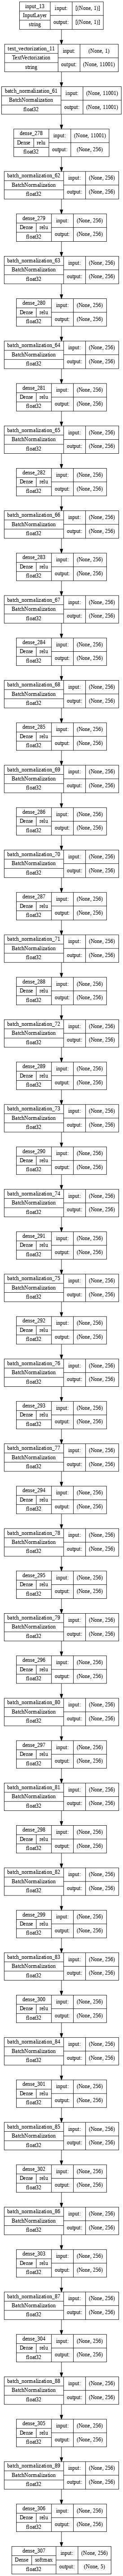

In [176]:
plot_model(model_bn, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

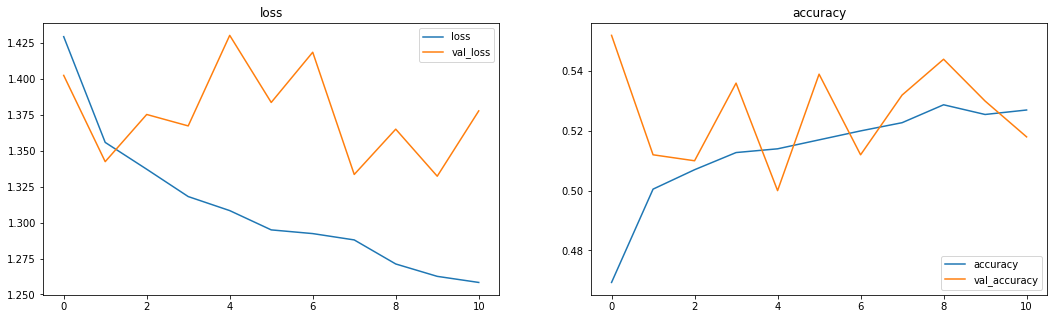

In [177]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_bn.history)

In this case, the model is not overfitting, in the train set I see an increasing of the accuracy, but in validation set it's going up and down, it's not properly learning, I see better performance in train set


In [182]:
# Do the same with `build_residual_model_residual_batch_normalization`
""" your code here """
model_rbn = build_residual_model_residual_batch_normalization(vectorize_layer, 'relu', 30, hidden_dim)

# Configure the model and start training
""" your code here """
model_rbn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_rbn = model_rbn.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 15s 67ms/step - loss: 1.4380 - accuracy: 0.4712 - val_loss: 1.3737 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 7s 59ms/step - loss: 1.3502 - accuracy: 0.5035 - val_loss: 1.3103 - val_accuracy: 0.5050
Epoch 3/100
125/125 [==============================] - 7s 60ms/step - loss: 1.3280 - accuracy: 0.5008 - val_loss: 1.3379 - val_accuracy: 0.5270
Epoch 4/100
125/125 [==============================] - 7s 59ms/step - loss: 1.3104 - accuracy: 0.5110 - val_loss: 1.3314 - val_accuracy: 0.5200
Epoch 5/100
125/125 [==============================] - 8s 61ms/step - loss: 1.3004 - accuracy: 0.5170 - val_loss: 1.4248 - val_accuracy: 0.4950
Epoch 6/100
125/125 [==============================] - 8s 61ms/step - loss: 1.2830 - accuracy: 0.5257 - val_loss: 1.4183 - val_accuracy: 0.4950
Epoch 7/100
125/125 [==============================] - 8s 61ms/step - loss: 1.2776 - accuracy: 0.5257 - val_loss: 1.3523 - val_accuracy

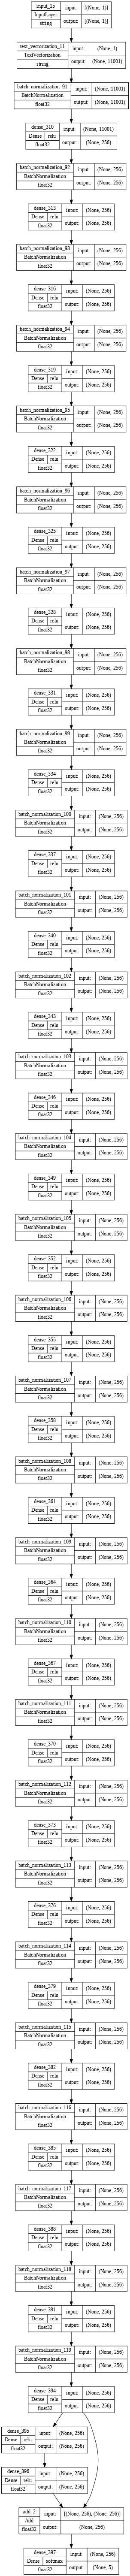

In [183]:
plot_model(model_rbn, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

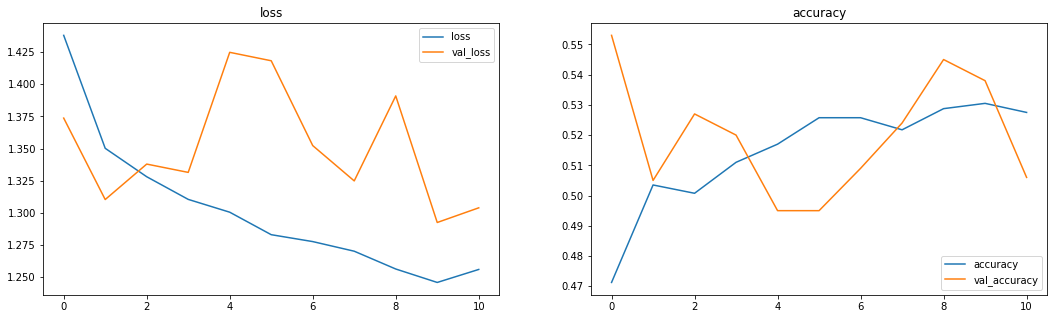

In [184]:
babysit(history_rbn.history)

it's not learning but I don't see anymore a overfitting, and in both of them I don't see a big difference( in residuals and batch vs batch nor). In both I see a better fitting of the train set, probably because the data are more.

### e) What if you simply reduce the network depth ?

<font color="red">[ TO DO STUDENTS ]</font>
* build a MLP with ReLU activation composed of 10 hidden layers
* compare your results both in terms of learning and performances compared to other models

In [188]:
#Build and train the network without residual connections
model_semple = build_model(vectorize_layer, 'relu', 10, hidden_dim)   ##let's see with 10 hidden layers

In [189]:
# Configure the model and start training
""" your code here """
model_semple.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_semple = model_semple.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 4s 25ms/step - loss: 1.4487 - accuracy: 0.5312 - val_loss: 1.3274 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 3s 22ms/step - loss: 1.3130 - accuracy: 0.5347 - val_loss: 1.2819 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 3s 22ms/step - loss: 1.2930 - accuracy: 0.5347 - val_loss: 1.2745 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 3s 22ms/step - loss: 1.2868 - accuracy: 0.5347 - val_loss: 1.2717 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 3s 23ms/step - loss: 1.2811 - accuracy: 0.5347 - val_loss: 1.2656 - val_accuracy: 0.5530
Epoch 6/100
125/125 [==============================] - 3s 22ms/step - loss: 1.2711 - accuracy: 0.5347 - val_loss: 1.2534 - val_accuracy: 0.5530
Epoch 7/100
125/125 [==============================] - 3s 23ms/step - loss: 1.2523 - accuracy: 0.5347 - val_loss: 1.2314 - val_accuracy:

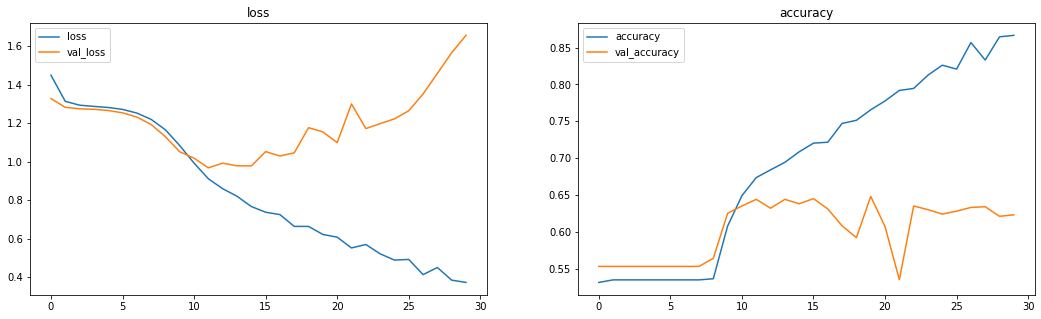

In [190]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_semple.history)

In this example is a overfitting, why? the loss of the validation set is increasing and the loss of the train set is decrissing

in the second case, the accuracy of the training set is incresing, the accuracy of validation set is decresing, so the model is overfitting in the train set

Normally, you observed a typical instance of overfitting.

## 4.  Underfitting and Overfitting problems

Actually what you observed in the last experiment is a typical instance of overfitting.

### a) Decrease the network size ?

In [191]:
#Build and train the network without residual connections
model_und = build_model(vectorize_layer, 'relu', 5, hidden_dim)

In [192]:
# Configure the model and start training
""" your code here """
model_und.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_und = model_und.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 3s 22ms/step - loss: 1.4675 - accuracy: 0.5207 - val_loss: 1.3475 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 2s 19ms/step - loss: 1.3197 - accuracy: 0.5347 - val_loss: 1.2826 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 2s 19ms/step - loss: 1.2856 - accuracy: 0.5347 - val_loss: 1.2644 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 2s 19ms/step - loss: 1.2631 - accuracy: 0.5347 - val_loss: 1.2431 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 2s 18ms/step - loss: 1.2344 - accuracy: 0.5347 - val_loss: 1.2154 - val_accuracy: 0.5530
Epoch 6/100
125/125 [==============================] - 2s 19ms/step - loss: 1.1961 - accuracy: 0.5385 - val_loss: 1.1792 - val_accuracy: 0.5670
Epoch 7/100
125/125 [==============================] - 2s 19ms/step - loss: 1.1432 - accuracy: 0.5730 - val_loss: 1.1262 - val_accuracy:

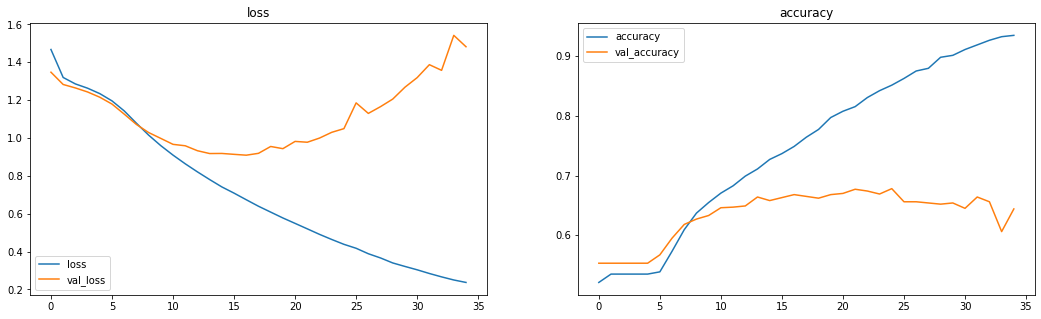

In [193]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_und.history)

For me: it gets slightly better but almost the same behavior is observed when taking 10 and 5 hidden layers.

What's going on for you ?

Yes I can confirm that it dosen't change much from 10 to 5, in both of them I have a overfitting

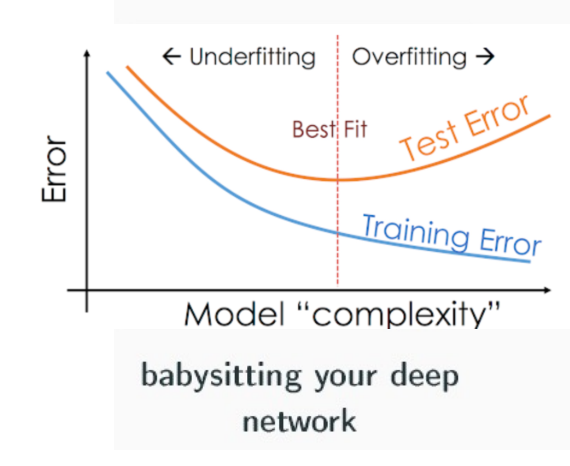

### b) Experiment on L2 regularization

<font color="red">[ TO DO STUDENTS ]</font>
* check the keras documentation on regularizations https://keras.io/api/layers/regularizers/
* Add to the previous network L2 regularization: first with l2_reg = 0.01 / then with l2_reg= 0.0001
* Compare results

In [198]:
# Design the model function
from tensorflow.keras import regularizers

def build_model_reg(vectorizer, activation, n_hiddenlayers, hidden_dim, l2_reg = 0.01):
    """ your code here """
    """ your code use: kernel_regularizer and bias_regularizer parameters of Dense"""
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    #x = Dense(units=hidden_dim, activation=activation)(inputs)
    for i in range(n_hiddenlayers-1):
        x = Dense(units=hidden_dim, activation=activation, kernel_regularizer=regularizers.L2(0.01), bias_regularizer=regularizers.L2(0.01))(x)
    outputs = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [199]:
#Build and train the network without residual connections
model_L2 = build_model_reg(vectorize_layer, 'relu', 5, hidden_dim, 0.01)


In [200]:
# Configure the model and start training
""" your code here """
model_L2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_L2 = model_L2.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 5s 33ms/step - loss: 13.8340 - accuracy: 0.5290 - val_loss: 13.4071 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 4s 30ms/step - loss: 13.0874 - accuracy: 0.5347 - val_loss: 12.7588 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 4s 31ms/step - loss: 12.4813 - accuracy: 0.5347 - val_loss: 12.1807 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 4s 30ms/step - loss: 11.9169 - accuracy: 0.5347 - val_loss: 11.6334 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 4s 31ms/step - loss: 11.3781 - accuracy: 0.5347 - val_loss: 11.1103 - val_accuracy: 0.5530
Epoch 6/100
125/125 [==============================] - 4s 30ms/step - loss: 10.8615 - accuracy: 0.5347 - val_loss: 10.6088 - val_accuracy: 0.5530
Epoch 7/100
125/125 [==============================] - 4s 31ms/step - loss: 10.3638 - accuracy: 0.5355 - val_loss: 10.1237 -

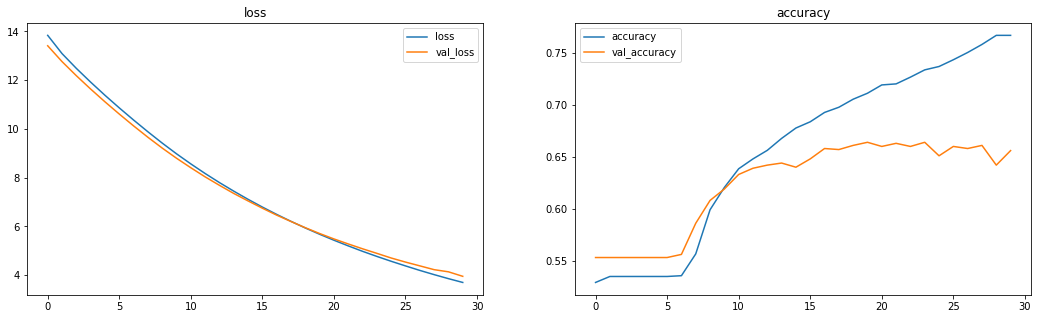

In [201]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_L2.history)

In the plot I don't see a good lerning,the models learns better in train set but I see even learning in validation, I can say even overfitting but not like in the previus examples, but I see improvments because in the loss both more or less decrease in the same directions

<font color="red">[ TO DO STUDENTS]</font code="red">

Reduce the coefficient of L2 regularization taken into account in the loss from l2_reg = 0.01 > to l2_reg = 0.0001 and do the same experimentation.

In [202]:
""" your code here """
def build_model_reg_less(vectorizer, activation, n_hiddenlayers, hidden_dim, l2_reg = 0.01):
    """ your code here """
    """ your code use: kernel_regularizer and bias_regularizer parameters of Dense"""
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    #x = Dense(units=hidden_dim, activation=activation)(inputs)
    for i in range(n_hiddenlayers-1):
        x = Dense(units=hidden_dim, activation=activation, kernel_regularizer=regularizers.L2(0.0001), bias_regularizer=regularizers.L2(0.0001))(x)
    outputs = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [203]:
#Build and train the network without residual connections
model_L2_less = build_model_reg_less(vectorize_layer, 'relu', 5, hidden_dim, 0.01)

In [204]:
# Configure the model and start training
""" your code here """
model_L2_less.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_L2_less = model_L2_less.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 5s 33ms/step - loss: 1.5793 - accuracy: 0.5300 - val_loss: 1.4578 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 4s 30ms/step - loss: 1.4344 - accuracy: 0.5347 - val_loss: 1.4017 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 4s 30ms/step - loss: 1.3959 - accuracy: 0.5347 - val_loss: 1.3738 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 4s 30ms/step - loss: 1.3592 - accuracy: 0.5350 - val_loss: 1.3412 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 4s 30ms/step - loss: 1.3137 - accuracy: 0.5470 - val_loss: 1.2982 - val_accuracy: 0.5770
Epoch 6/100
125/125 [==============================] - 4s 31ms/step - loss: 1.2516 - accuracy: 0.5888 - val_loss: 1.2414 - val_accuracy: 0.6070
Epoch 7/100
125/125 [==============================] - 4s 30ms/step - loss: 1.1822 - accuracy: 0.6235 - val_loss: 1.1928 - val_accuracy:

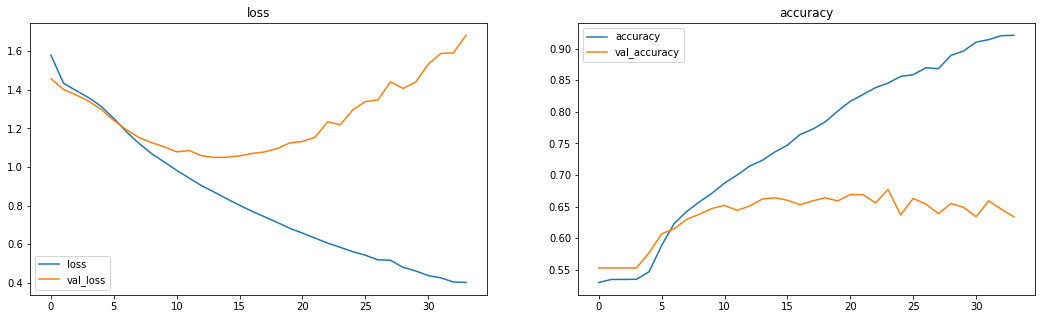

In [205]:
babysit(history_L2_less.history)

With l2_reg = 0.0001, the model is worse, here I see a overfitting.

What is your conclusion ?

### c) Experiment on Dropout

<font color="red">[TO DO STUDENTS]</font>
* Observe the provided results for a dropout ratio of p=0.7 and p=0.3
* What are your conclusions ?
* In the end, considering all the explored settings in this Lab, what would you suggest as a network to get a better model ?

In [209]:
# Design the model function
from keras.layers import Dropout

def build_model_dropout(vectorizer, activation, n_hiddenlayers, hidden_dim, p = 0.5):
    """ your code here """
   
    inputs = Input(shape=(X_train.shape[1],), dtype=tf.string)
    x=vectorize_layer(inputs)
    #x = Dense(units=hidden_dim, activation=activation)(inputs)
    for i in range(n_hiddenlayers-1):
        x = Dense(units=hidden_dim, activation=activation, kernel_regularizer=regularizers.L2(0.0001), bias_regularizer=regularizers.L2(0.0001))(x)
        x = (Dropout(p))(x)
    outputs = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [215]:
# Build and train the network without residual connections
model_drop = build_model_dropout(vectorize_layer, 'relu', 10, hidden_dim, 0.7)

In [216]:
# Configure the model and start training
""" your code here """
model_drop.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_drop = model_drop.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 6s 40ms/step - loss: 1.8120 - accuracy: 0.4457 - val_loss: 1.6763 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 4s 36ms/step - loss: 1.6401 - accuracy: 0.5240 - val_loss: 1.6030 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5882 - accuracy: 0.5320 - val_loss: 1.5750 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 4s 36ms/step - loss: 1.5645 - accuracy: 0.5335 - val_loss: 1.5673 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5397 - accuracy: 0.5332 - val_loss: 1.5656 - val_accuracy: 0.5530
Epoch 6/100
125/125 [==============================] - 4s 36ms/step - loss: 1.5156 - accuracy: 0.5345 - val_loss: 1.5700 - val_accuracy: 0.5530
Epoch 7/100
125/125 [==============================] - 4s 36ms/step - loss: 1.4903 - accuracy: 0.5347 - val_loss: 1.5828 - val_accuracy:

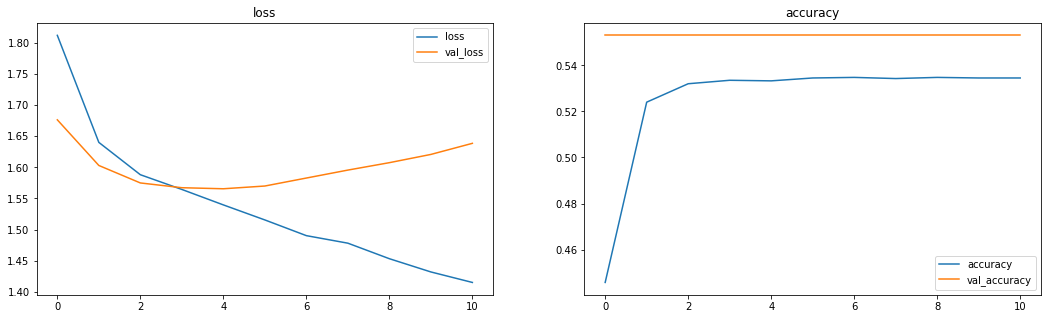

In [217]:
# Plot the learning curves and analyze them
""" your code here """
babysit(history_drop.history)

<font color="red">[ TO DO STUDENTS]</font code="red">

Decrease the proportion of neurons deactivated at each forward pass, from 0.7 to 0.3

In [218]:
""" your code here """
# Build and train the network without residual connections
model_drop_3 = build_model_dropout(vectorize_layer, 'relu', 10, hidden_dim, 0.3)

In [219]:
# Configure the model and start training
""" your code here """
model_drop_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_drop_3 = model_drop_3.fit(X_train, y_train_encoded, validation_split=0.2, epochs=100, callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - 6s 40ms/step - loss: 1.7151 - accuracy: 0.5310 - val_loss: 1.5934 - val_accuracy: 0.5530
Epoch 2/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5725 - accuracy: 0.5347 - val_loss: 1.5375 - val_accuracy: 0.5530
Epoch 3/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5523 - accuracy: 0.5347 - val_loss: 1.5325 - val_accuracy: 0.5530
Epoch 4/100
125/125 [==============================] - 4s 36ms/step - loss: 1.5494 - accuracy: 0.5347 - val_loss: 1.5311 - val_accuracy: 0.5530
Epoch 5/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5458 - accuracy: 0.5347 - val_loss: 1.5305 - val_accuracy: 0.5530
Epoch 6/100
125/125 [==============================] - 5s 36ms/step - loss: 1.5430 - accuracy: 0.5347 - val_loss: 1.5294 - val_accuracy: 0.5530
Epoch 7/100
125/125 [==============================] - 4s 36ms/step - loss: 1.5421 - accuracy: 0.5347 - val_loss: 1.5283 - val_accuracy:

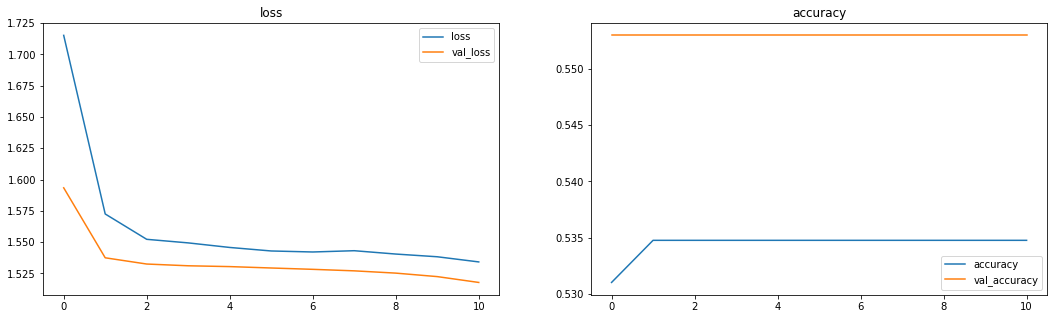

In [220]:
babysit(history_drop_3.history)

What is your conclusion ?

Non vedo un overfitting, but the model is not learning, in both cases. None of them is good model. 

For what I've seen until now , I think the best model is with the residuals connections, learns better like in train set, like in validation set. It genaralizes better the data.

## Stop and resume training

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! Fortunately, there is a solution - but when these situations occur, you need to know what to do:

1. Take a snapshot model that was saved/serialized to disk during training.
1. Load the model into memory.
1. Resume training where you left off.

Starting, stopping and resuming training is standard practice when setting the learning rate manually:

1. Start training your model until the loss/accuracy reaches a plateau.
1. Take a snapshot of your model every N epochs (typically N={1, 5, 10})
1. Stop training when you arrive at a plateau (by forcing out via ctrl + c or via earlystopping
1. Adjust your learning rate (typically by reducing it by an order of magnitude).
1. Restart the training script, starting from the last snapshot of the model weights

The ability to adjust the learning rate is an essential skill for any deep learning practitioner to master, so take the time to study and practice it!

<font color="red">Look at the documentation Tensorflow has proposed for ModelCheckpoint: we want to save the model at the end of each epoch so that we can restore it later.</font>

In [221]:
# Reuse one the previous model and reset it
# Use sgd as optimizer and fix learning_rate = 0.1
# Use 2 callbacks : EarlyStopping and ModelCheckpoint
# Save model at each epoch
# Fit the network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model_dropout(vectorize_layer, 'relu', 5, hidden_dim, 0.5)

opt = optimizers.SGD(learning_rate=0.1) # Fix learning rate to 0.1
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True),
                  ModelCheckpoint(
                       "C:/Users/Raffaele/Desktop/Lezioni/Deep_learning/slides/solution"
                       )]
history1 = model.fit(X_train, y_train_encoded, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

In [222]:
# Re-load the model
checkpoint_path = 'C:/Users/Raffaele/Desktop/Lezioni/Deep_learning/slides/solution'
new_model = tf.keras.models.load_model(checkpoint_path)

What is the difference between load_model and load_weights ?

``load_model`` is a function that enables you to restore a saved model, including the architecture, weights, optimizer, and state of the optimizer. This means that when you use load_model, you can get the exact same model, ready to use with the same training configuration, as when you saved it. It can be used to load a saved model from a save file.

``load_weights`` is a function that enables you to load the pre-trained weights of a model into a target model with the same architecture. The architecture of the target model should be the same as the model that was pre-trained.

In [223]:
# Change learning_rate = 0.01
new_model.optimizer.lr.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [224]:
# Continue to fit the network
history2 = new_model.fit(X_train, y_train_encoded, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

## Use Keras-tuner

<font color="red">[TO DO STUDENTS]</font>

From the previous experiences use Keras-tuner to find the best possible network.

Keras-Tuner must build at least 3 different network architectures:
* Dense cells only
* Addition of residuals
* Adding batch normalisation
* Adding dropout
* A combination of the different additions


In [225]:
pip install -q -U keras-tuner

In [94]:


import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt

#sources :
#https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
#https://keras.io/keras_tuner/

In [226]:


from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the model building function
def build_model(hyper_param):
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    x = vectorize_layer(input_layer)
    

#Dense
    for i in range(hyper_param.Int('n_dense_layers', 1, 3)):
        x = layers.Dense(hyper_param.Int('dense_units_' + str(i), 32, 256, 32), activation='relu')(x)
    
#Residual choice
    if hyper_param.Choice('residual', ['yes', 'no']) == 'yes':
        x = layers.add([x, x])
    
#Batch normalization
    if hyper_param.Choice('batch_norm', ['yes', 'no']) == 'yes':
        x = layers.BatchNormalization()(x)
    
    if hyper_param.Choice('dropout', ['yes', 'no']) == 'yes':
        x = layers.Dropout(hyper_param.Float('dropout_rate', 0, 0.7, step=0.1))(x)
    
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


tuner_rendom = RandomSearch(build_model, objective='val_accuracy', max_trials=60, directory='my_tuner1', project_name='my_project1', overwrite=True)


tuner_rendom.search(X_train, y_train_encoded, validation_split=0.2)

Trial 60 Complete [00h 00m 06s]
val_accuracy: 0.6710000038146973

Best val_accuracy So Far: 0.6710000038146973
Total elapsed time: 00h 04m 02s
